# Automatic assignment of genres from movie synopsis using supervised machine learning

## 1. Import libraries and load data

In [1]:
#packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import json
from textblob import TextBlob, Word
import nltk
import re
import csv
import matplotlib.pyplot as plt 
#import seaborn as sns
#from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Model

from keras.preprocessing.sequence import pad_sequences
#from keras.layers import GlobalAveragePooling1D, concatenate, SpatialDropout1D, Conv1D,Bidirectional
from keras.layers import Dense, Embedding, Input, LSTM, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing import sequence
#from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## 2. DATA PREPARATION 

In [4]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# function for text cleaning 
def preprocess_text(text):
    text = text.lower() # lowercase
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text) #line breaks
    #text = re.sub(r"\'\xa0", " ", text) # xa0 Unicode representing spaces
    #text = re.sub('\s+', ' ', text) # one or more whitespace characters
    text = text.strip(' ') # spaces
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    #lemmatize and remove stopwords
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    text = ' '.join(no_stopword_text) 
        
    return text

train['clean_plot'] = train['synopsis'].apply(lambda x: preprocess_text(x))
test['clean_plot'] = test['synopsis'].apply(lambda x: preprocess_text(x))

In [6]:
def lemma(text): # Lemmatization of cleaned body
        sent = TextBlob(text)
        tag_dict = {"J": 'a', 
                    "N": 'n', 
                    "V": 'v', 
                    "R": 'r'}
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
        seperator=' '
        lemma = seperator.join(lemmatized_list) 
        return lemma

In [7]:
train['lemma'] = train['clean_plot'].apply(lambda x: lemma(x))
test['lemma'] = test['clean_plot'].apply(lambda x: lemma(x))
train.head()

,movie_id,year,synopsis,genres,clean_plot,lemma
0,30924,2005,Cruel But Necessary is the story of Betty Muns...,Drama,cruel necessary story betty munson strange jou...,cruel necessary story betty munson strange jou...
1,34841,2012,"Yorkshire, 1974, the Maynard family moves into...",Drama Horror Thriller,yorkshire maynard family moves dream house dre...,yorkshire maynard family move dream house drea...
2,23408,2017,When a renowned architecture scholar falls sud...,Drama,renowned architecture scholar falls suddenly i...,renowned architecture scholar fall suddenly il...
3,39470,1996,The story dealt with Lord Rama and his retalia...,Children Drama,story dealt lord rama retaliation ravana chara...,story dealt lord rama retaliation ravana chara...
4,7108,2003,A Thai playboy cons a girl into bed and then l...,Comedy Drama Horror Thriller,thai playboy cons girl bed leaves finding preg...,thai playboy con girl bed leave find pregnant ...


## 3. Variables preparation 

In [8]:

X = train['lemma']

X_test = test['lemma']    

### 3.1 Target variable one hot encoding

In [9]:
#apply the onehot transformation for the genres vector
y = train['genres']
one_hot = MultiLabelBinarizer() # encoder for the  tags 
y_onehot = one_hot.fit_transform(y.str.split(' ')) 
y_bin = pd.DataFrame(y_onehot, columns=one_hot.classes_ ) # transform it to Pandas object

In [10]:
print(X.shape)
print(y_bin.shape)
y_bin.head()


(36518,)
(36518, 19)


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [11]:
# tokenize
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

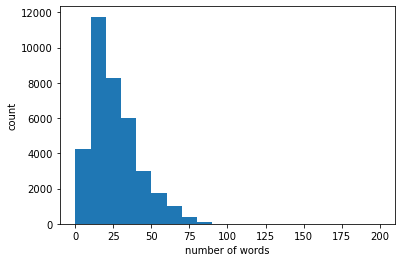

In [12]:
totalNumWords = [len(synopsis) for synopsis in list_tokenized_train]
bins = np.arange(0,210,10)
plt.hist(totalNumWords, bins)
plt.xlabel('number of words')
plt.ylabel('count')
plt.show()

In [13]:
#fix max comment lenght
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

## 4.The Model

In [14]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [15]:
#initialize parameters
inp = Input(shape=(maxlen, )) #maxlen defined earlier
embed_size = 128

In [16]:
# Neural network backbone
x = Embedding(max_features, embed_size)(inp)

x = LSTM(64, return_sequences=True,name='lstm_layer')(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(len(y_bin.columns), activation="softmax")(x)

In [17]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [18]:
batch_size = 16
epochs = 3
process_time_starts()
hist = model.fit(X_t,y_onehot, batch_size=batch_size, epochs=epochs, validation_split=0.1)
time_elapsed()

Epoch 1/3
2055/2055 [==============================] - 64s 31ms/step - loss: 0.2629 - accuracy: 0.3603 - val_loss: 0.2348 - val_accuracy: 0.4482
Epoch 2/3
2055/2055 [==============================] - 62s 30ms/step - loss: 0.2252 - accuracy: 0.4754 - val_loss: 0.2287 - val_accuracy: 0.4685
Epoch 3/3
2055/2055 [==============================] - 64s 31ms/step - loss: 0.2119 - accuracy: 0.5034 - val_loss: 0.2261 - val_accuracy: 0.4734
The process took: 0hour:3min:12sec


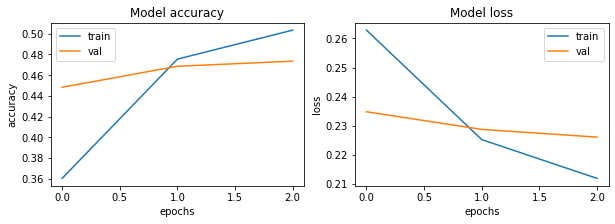

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 5.The prediction

In [20]:
y_pred = model.predict(X_te, batch_size=batch_size, verbose=1)
print(y_pred.shape)

329/329 [==============================] - 2s 7ms/step
(5250, 19)


In [21]:
df_probs_all = pd.DataFrame(y_pred,columns=y_bin.columns)
#df_probs = pd.DataFrame(index=y_bin.index,columns=y_bin.columns)
df_probs_all.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.157299,0.117781,0.079621,0.023000,0.045494,0.011966,0.043262,0.051942,0.062946,0.000228,0.070086,0.030190,0.002256,0.015243,0.007647,0.214516,0.052082,0.008154,0.006288
1,0.061930,0.040847,0.046475,0.008978,0.030475,0.014483,0.464477,0.061759,0.015675,0.000049,0.026586,0.038604,0.012879,0.008628,0.006525,0.114653,0.016983,0.027218,0.002776
2,0.002865,0.003176,0.005433,0.004185,0.049114,0.003200,0.765457,0.131216,0.002590,0.000014,0.003143,0.000469,0.006963,0.001677,0.005679,0.005834,0.003383,0.005548,0.000053
3,0.078040,0.034343,0.022101,0.008365,0.066100,0.005354,0.005392,0.031520,0.049023,0.000066,0.305218,0.002417,0.000281,0.015306,0.004274,0.268583,0.102890,0.000421,0.000305
4,0.038160,0.004035,0.001056,0.000984,0.047272,0.251190,0.001238,0.263814,0.001316,0.021342,0.025119,0.000135,0.000712,0.110874,0.018731,0.001988,0.209569,0.000436,0.002029


In [24]:
def top_5_predictions(df):
    N = 5
    cols = df.columns[:-1].tolist()
    a = df[cols].to_numpy().argsort()[:, :-N-1:-1]
    c = np.array(cols)[a]
    d = df[cols].to_numpy()[np.arange(a.shape[0])[:, None], a]
    df1 = pd.DataFrame(c).rename(columns=lambda x : f'max_{x+1}_col')

    predicted_genres = df1["max_1_col"] + ' ' + df1["max_2_col"]+ ' ' +df1["max_3_col"]+ ' ' + df1["max_4_col"]+ ' '+df1["max_5_col"]
    return predicted_genres

In [25]:
pred_gen = top_5_predictions(df_probs_all)

In [26]:
submission = pd.DataFrame(data= {'movie_id':test.movie_id,'predicted_genres':pred_gen})

In [27]:
submission.head()

,movie_id,predicted_genres
0,10827,Sci-Fi Action Adventure Animation Horror
1,51768,Documentary Sci-Fi Action Drama Animation
2,36064,Documentary Drama Comedy Musical Sci-Fi
3,33763,Horror Sci-Fi Thriller Action Comedy
4,1146,Drama Crime Thriller Mystery Comedy


In [28]:
submission.to_csv('submission.csv',index=False)